In [1]:
import os
import sys

%load_ext autoreload
%autoreload 2

module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

from src import Interception2D
from src.scenarios import make_escape_scenarios, plot_scenarios
from src.common import n_degree_curve
from pathlib import Path
import numpy as np
import pandas as pd
from joblib import Parallel, delayed, dump
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib import cm

BASE_PATH = Path(os.getcwd())
for _ in range(len(BASE_PATH.parents) + 1):
    if os.path.basename(BASE_PATH) == 'SmartInterception':
        break
    BASE_PATH = BASE_PATH.parents[0]

In [2]:
def f(d, q):
    scenarios, _ = make_escape_scenarios(
        n=1, 
        seed=1, 
        target_centered=True,
        d_min=d,
        d_max=d,
        q_min=q,
        q_max=q,
        eps_min=0,
        eps_max=0
    )
    env = Interception2D(agent='target', bounds='bounds.yaml', scenarios=scenarios)
    obs = env.reset()
    r = [d, q]
    done = False
    while not done:
        action = 0
        obs, rewards, done, _ = env.step(action)
    hit = True if 'hit' in env.status.lower() else False
    r.extend([env.t, hit])
    return r

In [3]:
distances = np.linspace(1000, 80000, 10)
heading_angles = np.linspace(0, 180, 10)
scenarios = []

for d in distances:
    for q in heading_angles:
        scenarios.append((d, q))

In [9]:
data = Parallel(n_jobs=-2, verbose=10)(delayed(f)(combination[0], combination[1]) for combination in scenarios)
data = np.array(data)
df = pd.DataFrame({'d': data[:, 0], 'q': data[:, 1], 't': data[:, 2], 'hit': data[:, 3]})
df['k'] = 1 - df.t / max(df.t)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1207s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-2)]: Batch computation too slow (2.1154s.) Setting batch_size=1.
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-2)]: Done  75 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-2)]: Done  86 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-2)]: Done  98 out of 100 | elapsed:   31.9s remaining:    0.6s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   32.1s finished


In [13]:
df

,d,q,t,hit,k
0,1000.0,0.0,4.0,1.0,0.967267
1,1000.0,20.0,4.3,1.0,0.964812
2,1000.0,40.0,4.1,0.0,0.966448
3,1000.0,60.0,2.4,0.0,0.980360
4,1000.0,80.0,1.7,0.0,0.986088
...,...,...,...,...,...
95,80000.0,100.0,103.3,0.0,0.154664
96,80000.0,120.0,89.3,0.0,0.269231
97,80000.0,140.0,89.3,0.0,0.269231
98,80000.0,160.0,84.1,1.0,0.311784


<IPython.core.display.Javascript object>


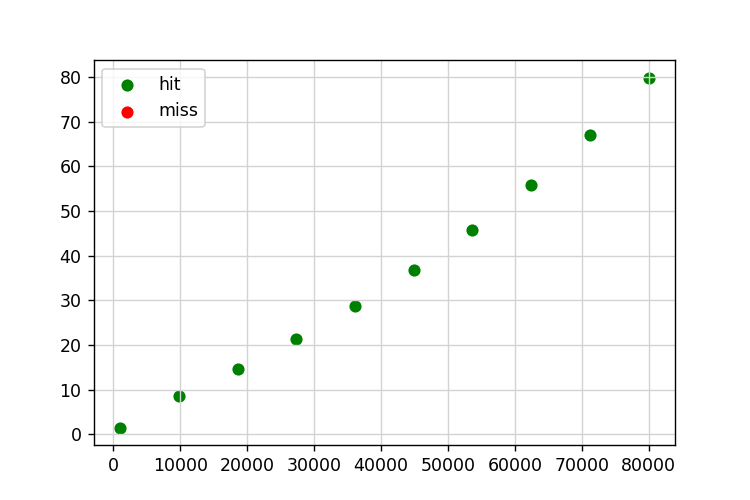

In [18]:
q = 180

fig = plt.figure(figsize=(6, 4))
plt.scatter(df[(df.q == q) & (df.hit == 1)].d, df[(df.q == q) & (df.hit == 1)].t, color='g', label='hit')
plt.scatter(df[(df.q == q) & (df.hit == 0)].d, df[(df.q == q) & (df.hit == 0)].t, color='r', label='miss')

plt.legend()
plt.grid(c='lightgray')
plt.show()

In [96]:
K = np.reshape(df.k.to_numpy(), (len(distances), len(heading_angles)))
        
interp = interpolate.interp2d(
    heading_angles,
    distances,
    K, 
    kind='linear'
)

<IPython.core.display.Javascript object>


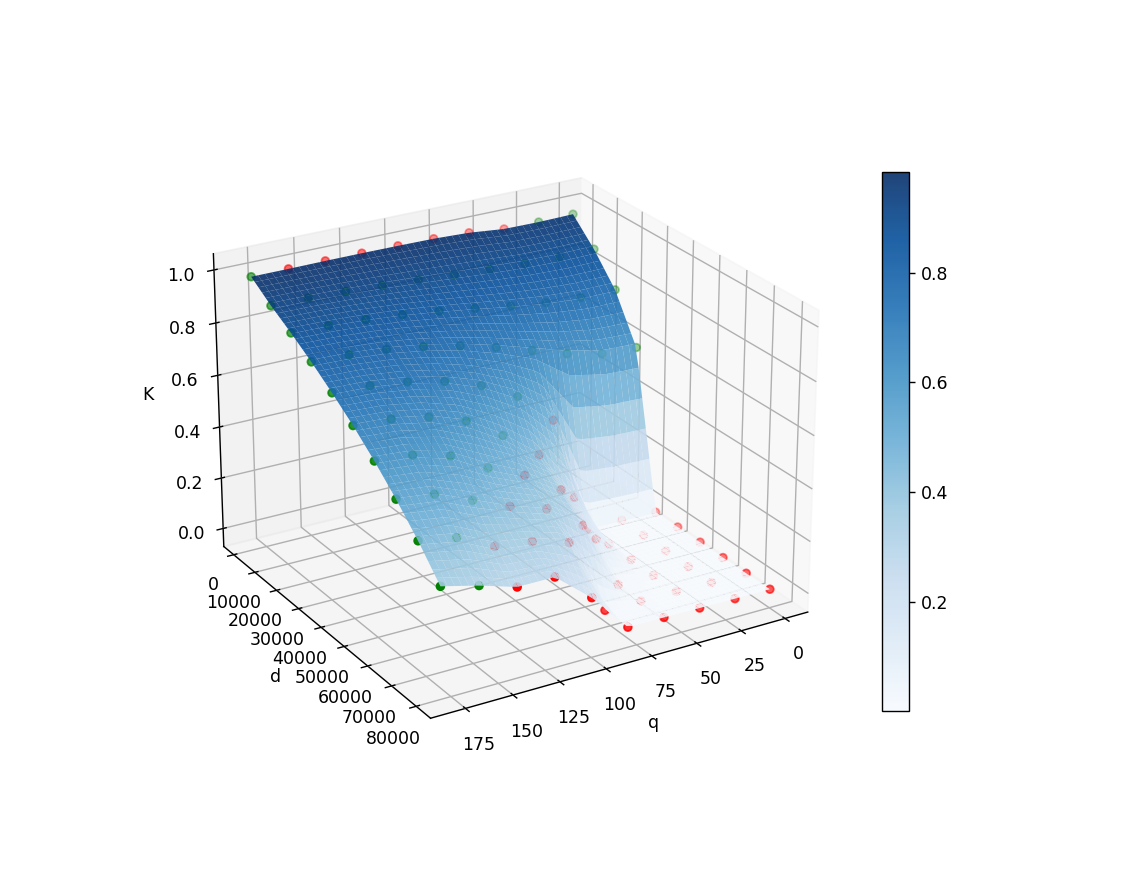

In [123]:
%matplotlib notebook
fig = plt.figure(figsize=(9, 7))
ax = plt.axes(projection='3d')

ax.scatter(df[(df.hit == 1)].q, df[(df.hit == 1)].d, df[(df.hit == 1)].k, color='g', label='hit')
ax.scatter(df[(df.hit == 0)].q, df[(df.hit == 0)].d, df[(df.hit == 0)].k, color='r', label='miss')

y = np.linspace(min(df.d), max(df.d), 50)
x = np.linspace(min(df.q), max(df.q), 50)
X, Y = np.meshgrid(x, y)
Z = interp(x, y)

surf = ax.plot_surface(X, Y, Z, cmap=cm.Blues, linewidth=2, alpha=0.9)
fig.colorbar(surf, shrink=0.8, aspect=20)

ax.set(xlabel='q', ylabel='d', zlabel='K')

plt.show()

In [105]:
dump(interp, '../files/importance.pkl')

['../src/environments/importances.pkl']